# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento  en un problema de k-armed bandit para la familia de algoritmos UCB.

- Se generan gráficas de recompensas promedio para cada algoritmo.
- Se generan gráficas de selecciones óptimas para cada algoritmo.
- Se generan gráficas de estadísticas de brazos para cada algoritmo.
- Se generan gráficas de arrepentimiento promedio para cada algoritmo.



# Autores: 
- Alejandro López Cuéllar
- Miguel Ángel Vera Frutos
- Alejandro Belda Fernández

## Librerias

In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/eml_k_bandit')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, ArmBernoulli, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['c:\\Users\\migue\\OneDrive\\Documentos\\GitHub\\k_brazos_VLB', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\migue\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0', '', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32\\lib', 'C:\\User

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Dado un bandido de k-brazos, se ejecutan algoritmos UCB con diferentes valores de alpha. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

Este código realiza el experimento del bandido multi-brazo. Para ello se ejecutan ejecuciones (`runs`) y pasos (`steps`), registrando recompensas promedio, porcentaje de selecciones óptimas y el arrepentimiento que es la diferencia entre la recompensa esperada del brazo óptimo y la del brazo seleccionado. Cada algoritmo elige un brazo, obtiene su recompensa y actualiza su estimación, mientras que se almacenan estadísticas sobre el número de veces que se ha seleccionado cada brazo y su recompensa promedio. Finalmente, los resultados se promedian sobre las ejecuciones y se retornan como matrices de recompensas, selecciones óptimas, estadísticas de los brazos y el arrepentimiento.

In [5]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret.


    arm_stats = [
        [{"arm": i + 1, "promedy_rewards": 0.0, "times_pulled": 0, "optimal": i==optimal_arm} for i in range(bandit.k)]
        for _ in range(len(algorithms))
        ]


    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.



    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                regret[idx, step] += current_bandit.get_expected_value(optimal_arm) - current_bandit.get_expected_value(chosen_arm)

                
                optimal_selections[idx, step] += (chosen_arm == optimal_arm)
                arm_stats[idx][chosen_arm]["times_pulled"] += 1
                arm_stats[idx][chosen_arm]["promedy_rewards"] += reward



    rewards /= runs
    regret /= runs
    for algo_idx in range(len(algorithms)):
        for arm_idx in range(bandit.k):
            if arm_stats[algo_idx][arm_idx]["times_pulled"] == 0:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = 0.0
            else:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] /= arm_stats[algo_idx][arm_idx]["times_pulled"]
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = np.round(arm_stats[algo_idx][arm_idx]["promedy_rewards"], 2)
            arm_stats[algo_idx][arm_idx]["times_pulled"] /= runs
            arm_stats[algo_idx][arm_idx]["times_pulled"] = round(arm_stats[algo_idx][arm_idx]["times_pulled"])
   

    optimal_selections /= runs

    return rewards, optimal_selections, arm_stats, regret


## Distribución Normal

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos UCB, siendo uno de ellos UCB1 y los otros 2 UCB2 con valores alpha de 0.1 y 0.01.

In [6]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.01)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados

#### Evolución Recompensa Promedio

Inicialmente mostraremos la evolucion de la recompensa promedio para los 3 algoritmos frente a los steps.

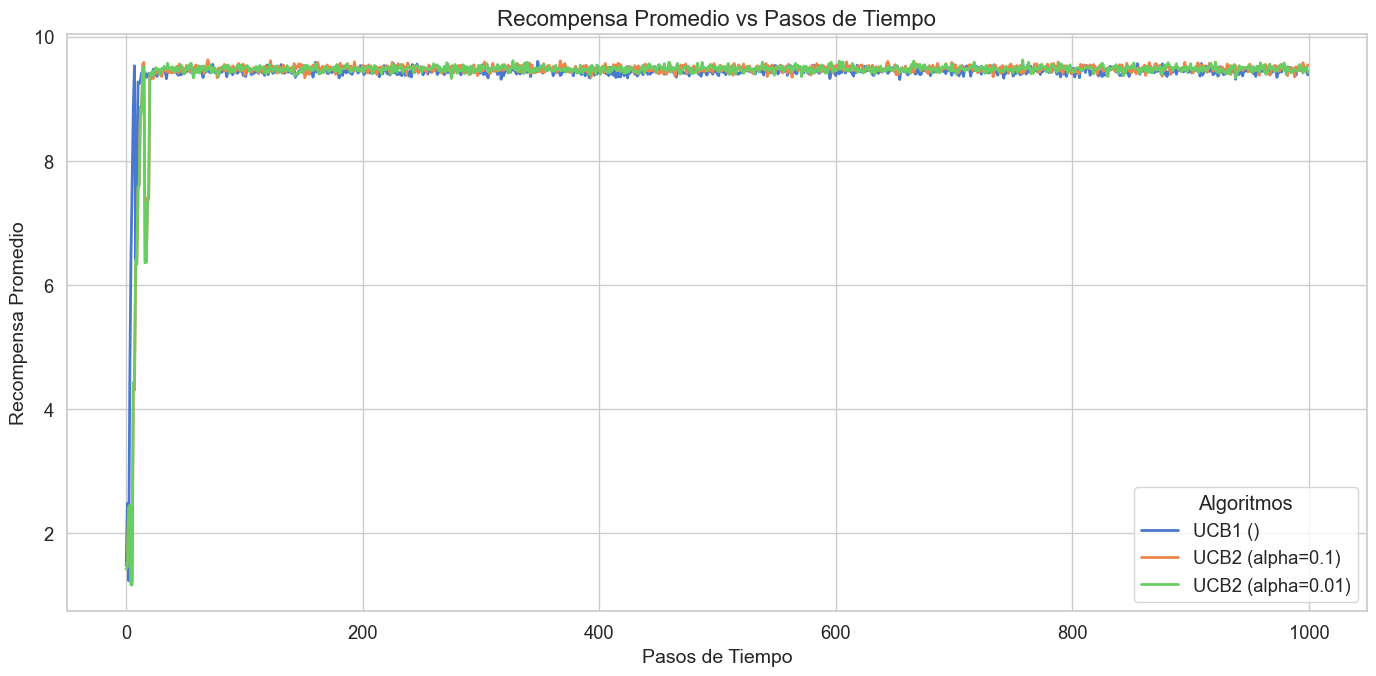

In [7]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)


#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **UCB** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Crecimiento de la recompensa promedio:**
   - La línea **azul (UCB1)** explora en primer lugar todos los brazos y en muy pocos pasos alcanza el brazo óptimo.
   - La línea **naranja (UCB2; alpha = 0.1)** muestra también un inicio explorando todos los brazos, y llega al brazo óptimo en unos pocos pasos más que UCB1.
   - La línea **verde (UCB2; alpha = 0.01)** al igual que los otros dos casos, llega al brazo óptimo en pocos pasos, además, se ve como debido al valor de alpha de 0.01 lleva a cabo una mayor exploración que lo que se aprecia en UCB y UCB2 con alpha=0.1.

---





#### Evolución Selección Brazo Optimo

Ahora continuamos mostrando la evolución del número de selecciones del brazo óptimo para cada uno de los 3 algoritmos.

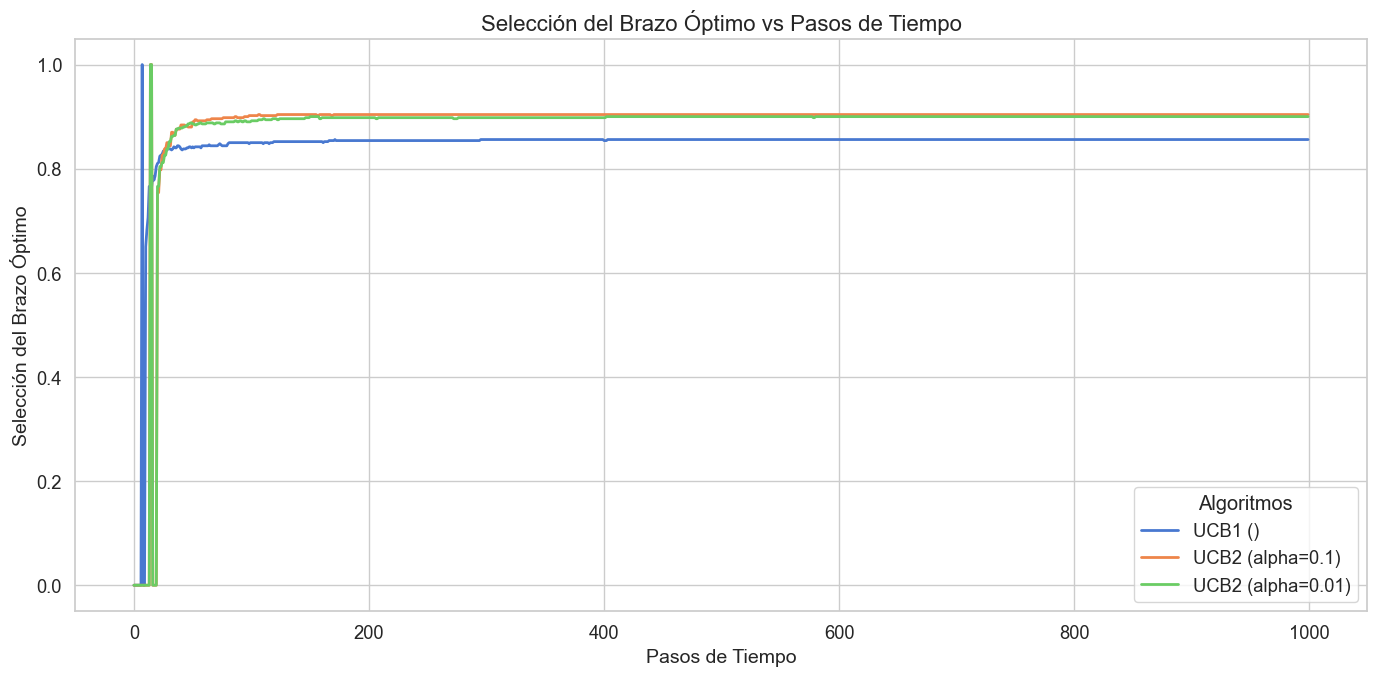

In [8]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Selección del brazo óptimo:**
   - La línea **azul (UCB1)** en un primer lugar pasa por el brazo óptimo ya que se debe pasar por todos los brazos, tras ello, no tarda en alcanzar el brazo óptimo, aunque se aprecia que el número de veces que se selecciona es inferior a los de UCB2.
   - La línea **naranja (UCB2; alpha = 0.1)** realiza de igual forma una pasada por todos los brazos de forma que se observa que al principio se selecciona el brazo óptimo, tras ello, en pocos pasos se alcanza el brazo óptimo que se selecciona en mayor medida que UCB1.
   - La línea **verde (UCB2; alpha = 0.01)** refleja que en una primera pasada por todos los brazos, el óptimo es seleccionado, una vez hecho esto, en unos pocos pasos más que los 2 casos anteriores, debido a una mayor exploración por **alpha=0.01**, se alcanza el brazo óptimo.

---

#### Estadisticas de los brazos

c:\Users\migue\OneDrive\Documentos\GitHub\k_brazos_VLB\plotting\plotting.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


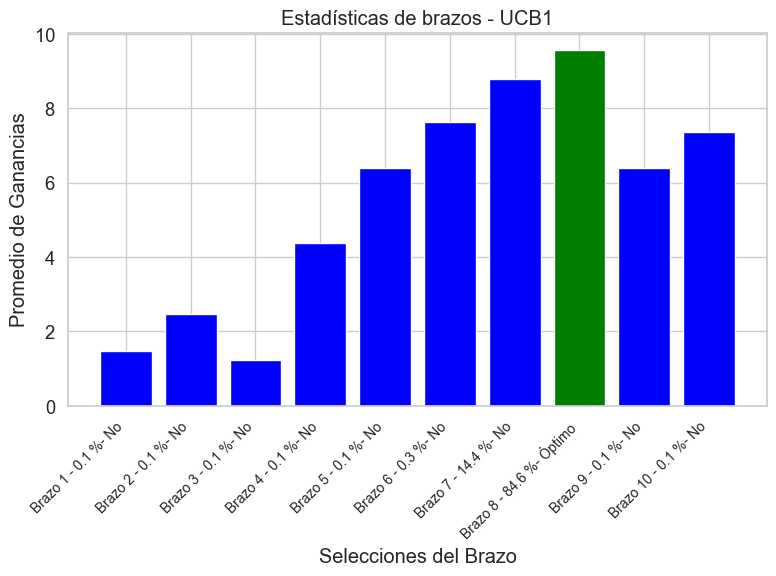

Recompensa Promedio del Brazo 1 : 1.48
Recompensa Promedio del Brazo 2 : 2.48
Recompensa Promedio del Brazo 3 : 1.23
Recompensa Promedio del Brazo 4 : 4.38
Recompensa Promedio del Brazo 5 : 6.4
Recompensa Promedio del Brazo 6 : 7.64
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.4
Recompensa Promedio del Brazo 10 : 7.35


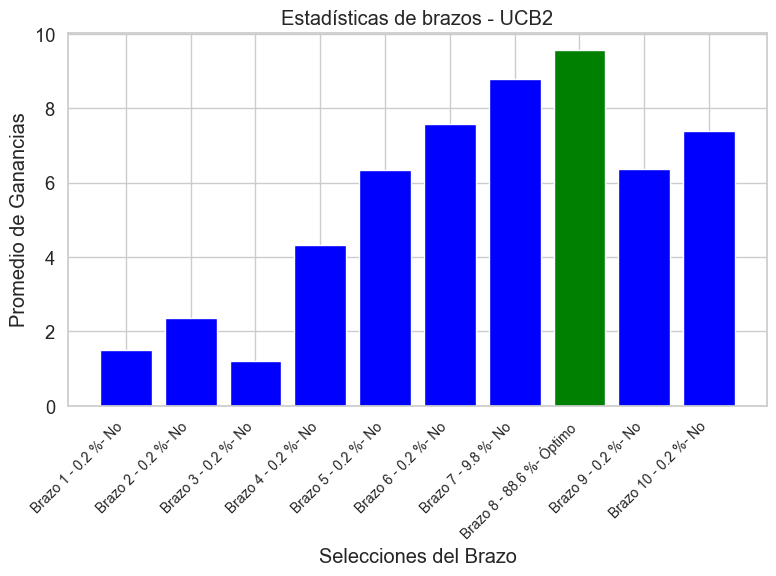

Recompensa Promedio del Brazo 1 : 1.51
Recompensa Promedio del Brazo 2 : 2.36
Recompensa Promedio del Brazo 3 : 1.21
Recompensa Promedio del Brazo 4 : 4.32
Recompensa Promedio del Brazo 5 : 6.33
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.79
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.37
Recompensa Promedio del Brazo 10 : 7.39


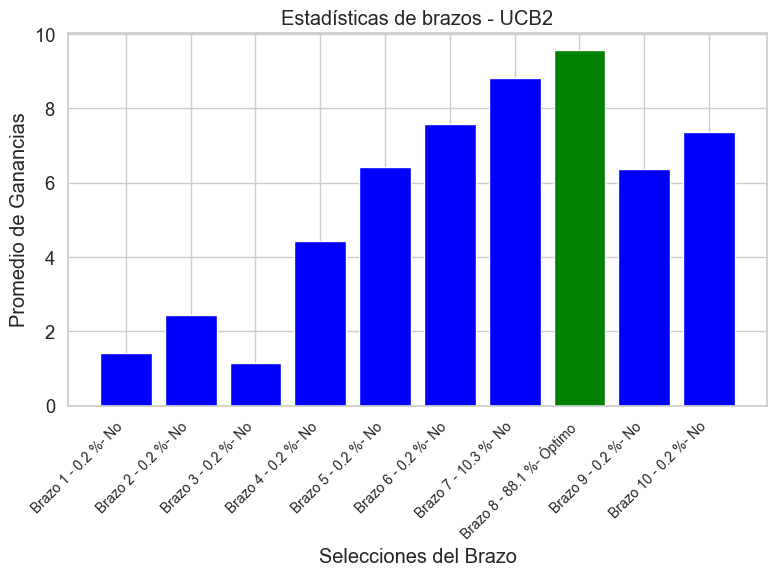

Recompensa Promedio del Brazo 1 : 1.43
Recompensa Promedio del Brazo 2 : 2.43
Recompensa Promedio del Brazo 3 : 1.16
Recompensa Promedio del Brazo 4 : 4.44
Recompensa Promedio del Brazo 5 : 6.42
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.81
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.36
Recompensa Promedio del Brazo 10 : 7.35


In [9]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **UCB1 y UCB2** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de alpha en el algoritmo UCB:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo UCB1, con una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.1, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.01, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$, este alpha algo menor al anterior permite una mayor exploración.

2. **Estadísticas brazos**
   - En el primer histograma (UCB1) se observa como el brazo que más veces es seleccionado es el óptimo, debido a la exploración realizada por UCB1 se permite alcanzar dicho brazo, además, como muestra el histograma, es seleccionado en el 84.6% de las ocasiones, seguido de un 14.4% por un brazo que obtiene un valor de recompensa también elevado, el resto de brazos por otra parte, es seleccionado un número mucho menor de ocasiones.
   - En el segundo histograma se aprecia que con UCB2, el balance entre explotación y exploración tiene como consecuencia un mejor resultado obteniendo que el brazo óptimo es seleccionado más veces que en UCB1, siendo en esta ocasión elegido el 88.6% de las veces, mientras que el segundo brazo más seleccionado es elegido un 9.8%.
   - El tercer histograma, al emplear UCB2, pero con un mayor componente de exploración, obtiene mejores resultados que los de UCB1, pero algo inferiores a UCB2 con alpha=0.1 debido a ese caracter exploratorio. Ya que el brazo óptimo es seleccionado un 88.1% de las veces, y el segundo brazo más seleccionado aumenta un poco el número de veces que es elegido, pasando a 10.3%.

---

#### Evolución del arrepentimiento promedio.

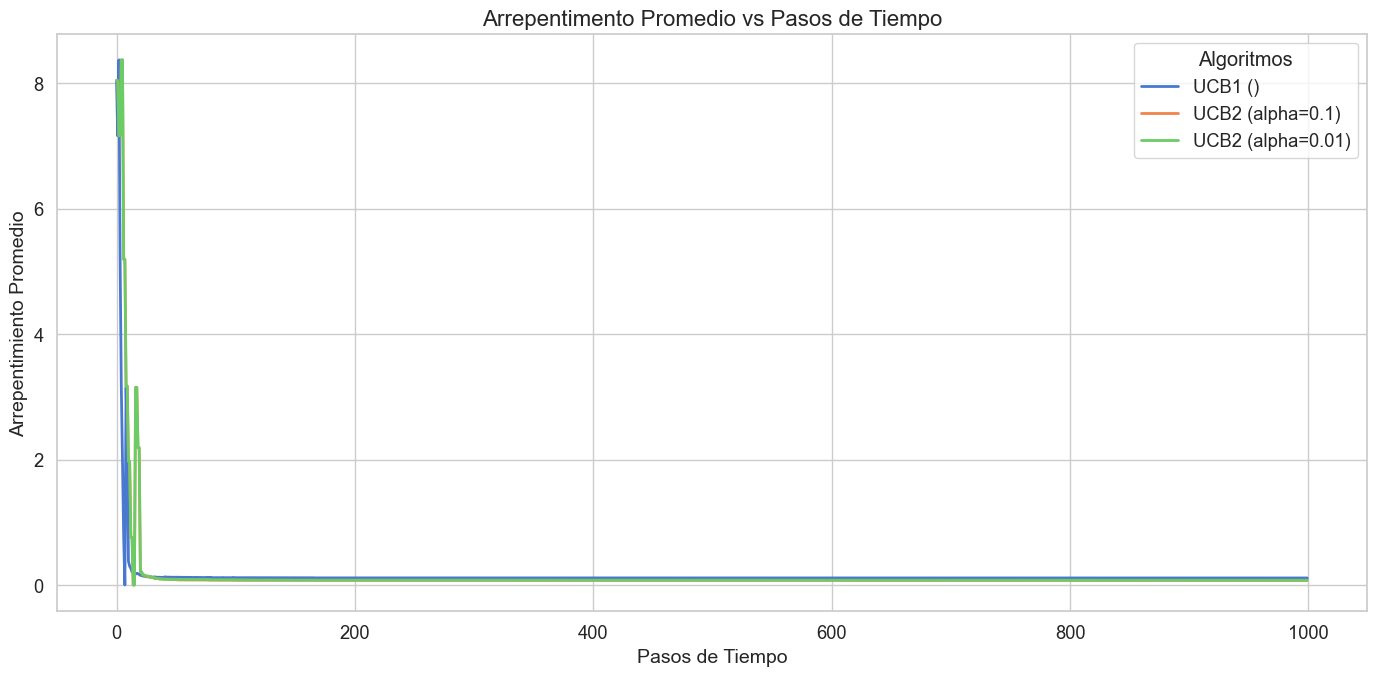

In [10]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Arrepentimiento promedio:**
   - La línea **azul (UCB1)** como se ve tarda menos en alcanzar el brazo óptimo, por lo que el regret se reduce drásticamente y vemos que lo hace en menos pasos que UCB2.  Sin embargo, el valor que obtiene de regret una vez se estabiliza vemos que es ligeramente superior al de los otros 2 casos.
   - La línea **verde (UCB2; alpha = 0.01)** tarda algo más en encontrar el brazo óptimo debido a un mayor comportamiendo de exploración, pese a ello, tras unos pocos pasos y habiendo pasado por cada uno de los brazos en un inicio, llega al brazo óptimo, obteniendo un regret menor que UCB1 una vez se estabiliza.
   - La línea **naranja (UCB2; alpha = 0.1)** muestra un comportamiento similar al de UCB2 con alpha=0.1, donde una vez habiendo pasado por todos los brazos, no tarda muchos pasos en alcanzar el brazo óptimo, obteniendo un regret menor al de UCB1 al alcanzar dicho brazo óptimo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado en el estudio de los algoritmos UCB1 y UCB2, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
Los algoritmos **UCB1** y **UCB2** balancean entre exploración y explotación:
- **UCB1**: Seleccionará el brazo con mayor valor UCB, siendo este la suma entre la recompensa esperada y el resultado de u(a), obtenido mediante la fórmula $\sqrt{\frac{2 \ln t}{N_t(a)}}$
- **UCB2 (alpha=0.1)**: Al igual, que UCB1, para seleccionar el brazo a emplear, realiza la suma entre el valor esperado de cada brazo con u(a), en esta ocasión siendo dicho valor calculado mediante $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Al establecer un valor de alpha 0.1, el valor de tau crece algo lento, permitiendo cierta exploración.
- **UCB2 (alpha=0.01)**: Se emplea igual la fórmula $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$ para el cálculo de u(a). En esta ocasión, como el valor de alpha es menor (0.01), el denominador de u(a) crece de forma más lenta que antes, permitiendo que dicho carácter exploratorio sea mayor en esta ocasión.


Los gráficos confirman este comportamiento:
- **azul (UCB1)** realiza una rápida exploración al inicio, y tarda poco en alcanzar el brazo óptimo, pasando en una primera instancia por cada uno de los brazos. Se observa sin embargo, que suele ofrecer un resultado ligeramente inferior a UCB2 ya que selecciona en menor cantidad de ocasiones el brazo óptimo.
- **naranja (UCB2; alpha=0.1)** al poseer un valor alpha ciertamente grande se aprecia como la exploración que realiza es similar a la de UCB1, vemos sin embargo que el desempeño de este algoritmo con este valor mejora de forma ligera los resultados obtenidos por UCB1 seleccionando una mayor cantidad de veces el brazo óptimo.
- **verde (UCB2; alpha=0.01)** muestra una mayor exploración al tener un valor alpha pequeño, además se observa en los resultados obtenidos superan por norma a los que se obtienen mediante UCB1.

#### **2. Convergencia de los algoritmos**
La convergencia de los algoritmos UCB1 y UCB2 con alpha=0.1 es ligeramente superior a la de UCB2 con alpha=0.01:
- Por el funcionamiento de UCB, siempre se realizará una pasada por cada uno de los brazos en una ronda inicial.
- Dicha pasada permite observar las recompensas de cada brazo, por lo que pese a que UCB2 con alpha 0.01 explore más, los otros algoritmos pueden alcanzar el brazo óptimo de una forma rápida.
- Pese a la convergencia rápida de UCB1, se aprecia que selecciona el brazo óptimo un número inferior de veces a lo que lo hace UCB2.


#### **3. Utilidad Graficos**

El gráfico de recompensa promedio nos permite analizar cómo los algoritmos mejoran en las recompensas obtenidas, ayudándonos a determinar si están identificando brazos con buenas recompensas o incluso el brazo óptimo. Evaluar el equilibrio entre exploración y explotación facilita la comprensión del comportamiento del algoritmo.

La gráfica de Selección del Brazo Óptimo refleja el proceso de exploración y explotación, permitiéndonos observar si los algoritmos identifican y priorizan el brazo óptimo, si continúan explorando otras opciones o si existe una falta de exploración que impida encontrar la mejor alternativa.

La gráfica de Estadísticas de Brazos proporciona información detallada sobre cada brazo, como su porcentaje de selecciones, la recompensa promedio obtenida, su identificación y si es el brazo óptimo. Esta información resulta útil para analizar la diferencia en recompensas entre los brazos, si el algoritmo está explotando el brazo óptimo o algún otro, así como el nivel de exploración y la distribución de selecciones.

Por último, la gráfica del Arrepentimiento Promedio nos muestra cómo varía este valor para cada algoritmo, lo que nos ayuda a interpretar sus decisiones en la selección de brazos, identificando si están eligiendo el brazo óptimo o si persisten en la explotación de otra opción.

Como valoración general, las gráficas que más información nos aportan son la de la recompensa promedio de cada algoritmo, así como la de selección del brazo óptimo. Y es que según el nivel de recompensas que se esté obteniendo, se puede intuir si el brazo óptimo está siendo seleccionado, o si por el contrario no ha sido alcanzado. Del mismo modo, al ser el arrepentimiento una gráfica que representa la diferencia entre la recompensa máxima y la obtenida en cada paso, observando los valores obtenidos en la gráfica de recompensa promedio también se puede intuir cómo será dicha gráfica de arrepentimiento.

#### **4. Aplicaciones y conclusiones**
- El algoritmo de UCB (Upper Confidence Bound) es útil en aquellos campos donde es algo crucial el balance entre exploración y explotación, ejemplos de esto podría ser optimización de publicidad en páginas web, ensayos clínicos, sistemas de recomendación en plataformas de streaming...

Como conclusión se observa, que los resultados obtenidos para este tipo de distribución (distribución normal), el algoritmo UCB2 con un valor de alpha=0.1 ha sido el que mejores resultados ha obtenido, superando de forma ligera UCB2 con alpha=0.01, el cual realiza algo más de exploración, y también superando UCB1, el cual suele converger de forma rápida hacia el brazo óptimo, sin realizar tanta exploración como con valores bajos de alpha en UCB2.

## Distribucion Binomial

### Ejecución del experimento

Volvemos a ejecutar el experimento pero esta vez los brazos seguiran una distribucion binomial.

In [11]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.01)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(probability=0.37, number=2), ArmBinomial(probability=0.95, number=2), ArmBinomial(probability=0.6, number=2), ArmBinomial(probability=0.73, number=2), ArmBinomial(probability=0.16, number=2), ArmBinomial(probability=0.06, number=2), ArmBinomial(probability=0.87, number=2), ArmBinomial(probability=0.71, number=2), ArmBinomial(probability=0.97, number=2), ArmBinomial(probability=0.02, number=2)
Optimal arm: 9 with expected reward=1.94


### Visualización de los resultados

#### Evolución Recompensa Promedio

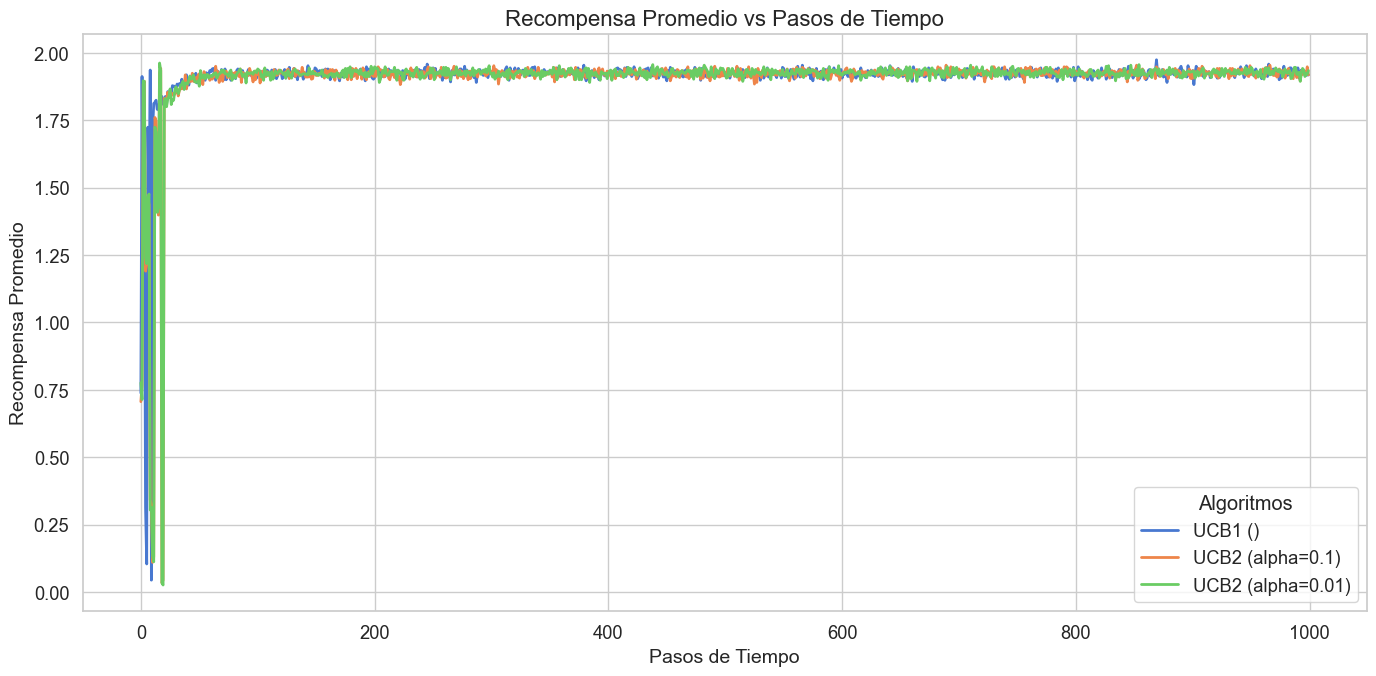

In [12]:
plot_average_rewards(steps, rewards, algorithms)

#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Crecimiento de la recompensa promedio:**
   - La línea **azul (UCB1)** tras unos pocos pasos, y tras pasar por todos los brazos en una primera vuelta, alcanza el brazo óptimo. De modo que comienza explorando los brazos y una vez da con el óptimo comienza a explotar.
   - La línea **naranja (UCB2; alpha = 0.1)** al igual que UCB1, hace una pasada por todos lo brazos y tras ello, en pocos pasos alcanza el óptimo, comenzando a explotar.
   - La línea **verde (UCB2; alpha = 0.01)** es el que mayor componente de exploración posee, debido al valor de alpha bajo. Por lo que tarda unos pocos pasos más en alcanzar el óptimo, debido a ese caracter exploratorio.


   En esta ocasión, se observa que las recompensas obtenidas son inferiores si se comparan con las recompensas que se obtenían para la distribución con la que se había tratado anteriormente.
---

#### Evolución Selección Brazo Optimo

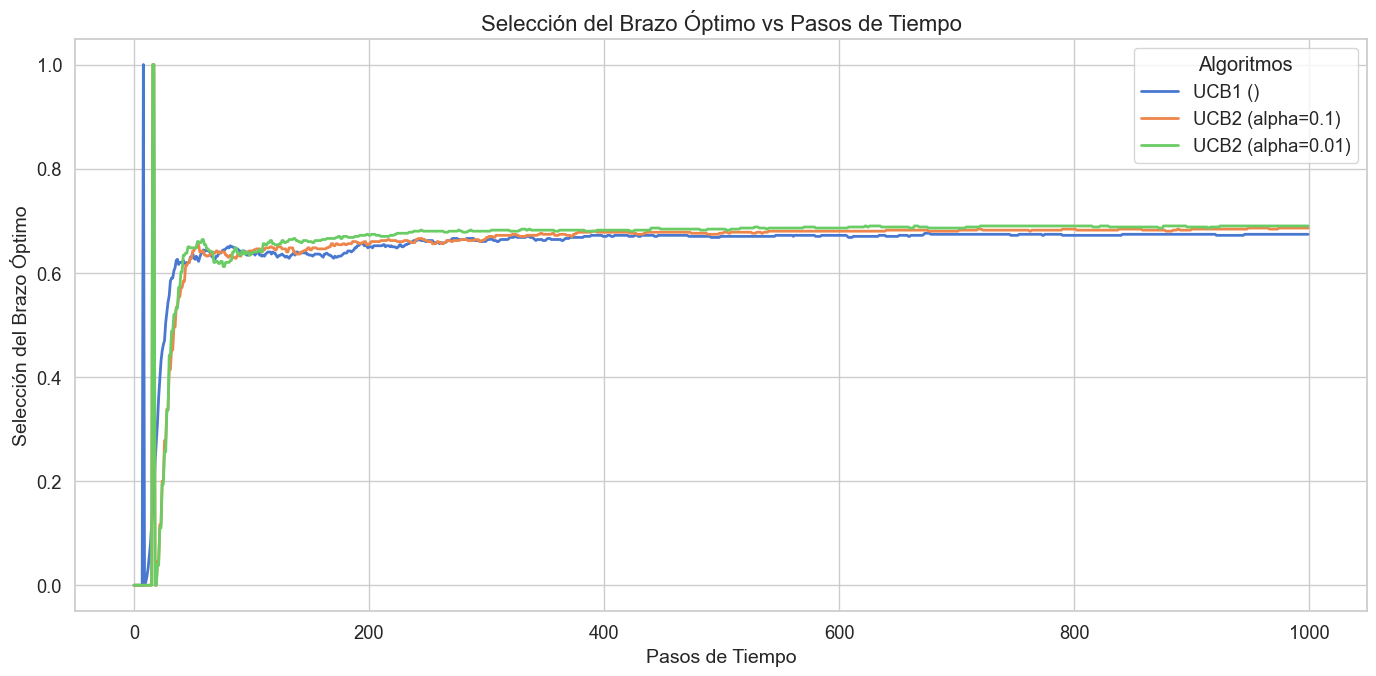

In [13]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Selección del brazo óptimo:**
   - La línea **azul (UCB1)** se observa como es la primera que alcanza el brazo óptimo, sin embargo, es la que en menor porcentaje lo selecciona, aunque sea por un margen pequeño.
   - La línea **naranja (UCB2; alpha = 0.1)** tras realizar mayor exploración, y tardar unos pocos pasos más, alcanza el brazo óptimo, es notable en esta ocasión, como el brazo óptimo es seleccionado en menor medida que con la otra distribución.
   - La línea **verde (UCB2; alpha = 0.01)** de forma similar a la línea naranja, lleva a cabo mayor exploración que UCB1, tras ello, alcanza el brazo óptimo, el cual lo selecciona  en mayor medida que lo apreciable en la línea azul, y de forma ligeramente superior también a lo mostrado en la línea naranja.

   Lo más destacable que notamos es que respecto a la distribución normal el brazo óptimo de promedio es elegido en una menor frecuencia, aunque esto se puede deber simplemente al componente de aleatoriedad de la exploración, haciendo que le costara más o empezar a explorar o en sí encontrar el mejor brazo.

---

#### Estadisticas de los brazos

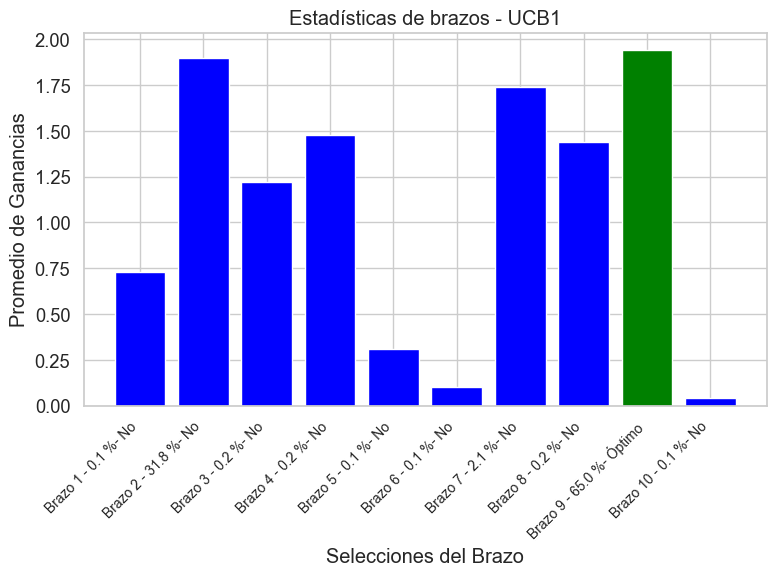

Recompensa Promedio del Brazo 1 : 0.73
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.22
Recompensa Promedio del Brazo 4 : 1.48
Recompensa Promedio del Brazo 5 : 0.31
Recompensa Promedio del Brazo 6 : 0.1
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.44
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


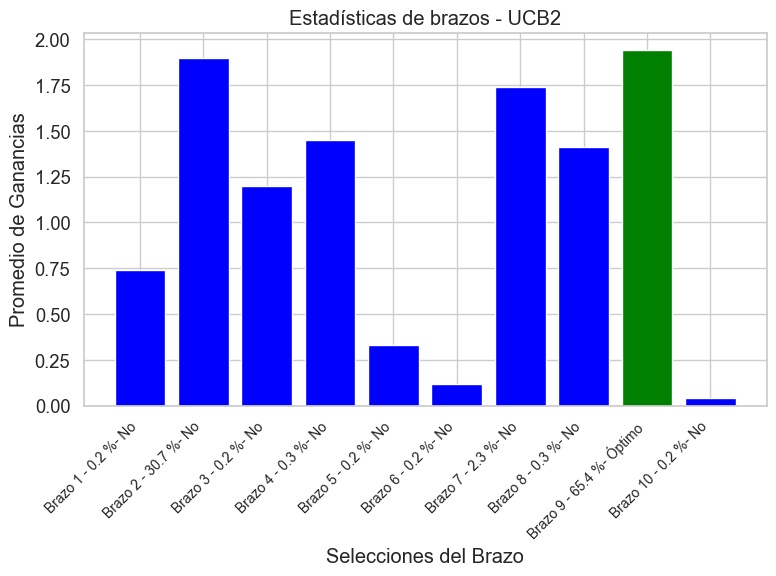

Recompensa Promedio del Brazo 1 : 0.74
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.2
Recompensa Promedio del Brazo 4 : 1.45
Recompensa Promedio del Brazo 5 : 0.33
Recompensa Promedio del Brazo 6 : 0.12
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.41
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


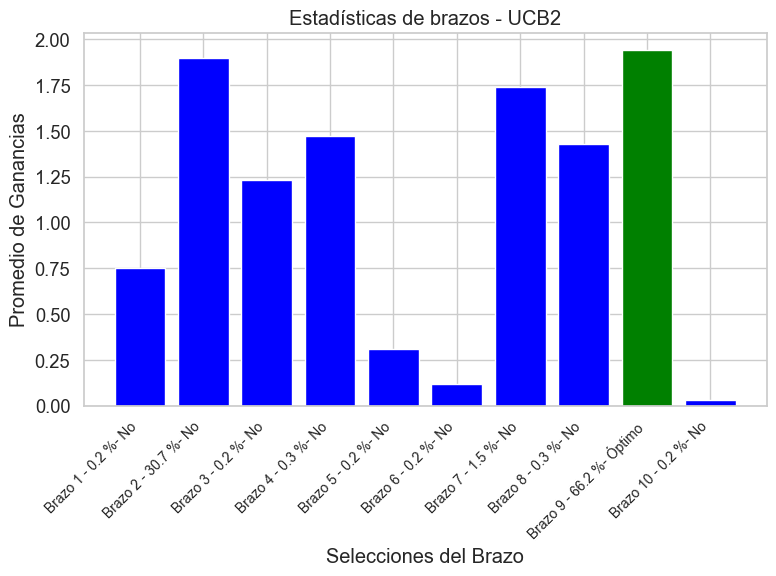

Recompensa Promedio del Brazo 1 : 0.75
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.23
Recompensa Promedio del Brazo 4 : 1.47
Recompensa Promedio del Brazo 5 : 0.31
Recompensa Promedio del Brazo 6 : 0.12
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.43
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.03


In [14]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **UCB** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de alpha en el algoritmo UCB:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo UCB1, con una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.1, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.01, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$, este alpha algo menor al anterior permite una mayor exploración.

2. **Estadísticas brazos**
   - En el primer histograma se puede observar como el brazo mayormente seleccionado es el brazo óptimo, sin embargo, existe otro brazo que posee una recompensa bastante similar, lo que provoca que UCB1 opte en ocasiones por seleccionar dicho brazo, por el componente de exploración de u(a). Por ello, el brazo óptimo se selecciona el 65% de las ocasiones y este segundo brazo un 31,8%.

   - En el segundo histograma como de igual forma el brazo que ha sido seleccionado en una mayor cantidad de ocasiones es el óptimo, sin embargo, por el comportamiento de UCB, debido a que el brazo 2 posee una recompensa similar a la que ofrece el brazo óptimo, también se selecciona en gran medida. Quedando así el brazo óptimo seleccionado el 65,4% de las ocasiones, mientras que el brazo 2 se selecciona un 30.7%. Se aprecia pues, que en comparación con UCB1 el brazo óptimo está siendo más elegido en esta ocasión.

   - Para el tercer histograma ocurre algo similar a lo del segundo histograma, obteniendo que el brazo óptimo se selecciona en mayor medida de lo que se hacía en UCB1. En cuanto al porcentaje de selección, vemos que es de 66.2% del brazo óptimo, mientra que el brazo 2 se mantiene en 30.7%. Por lo que son los brazos con porcentaje de selección inferior los que sufren aún más esa caída en pos de seleccionar el brazo óptimo.

---

#### Evolución del arrepentimiento promedio.

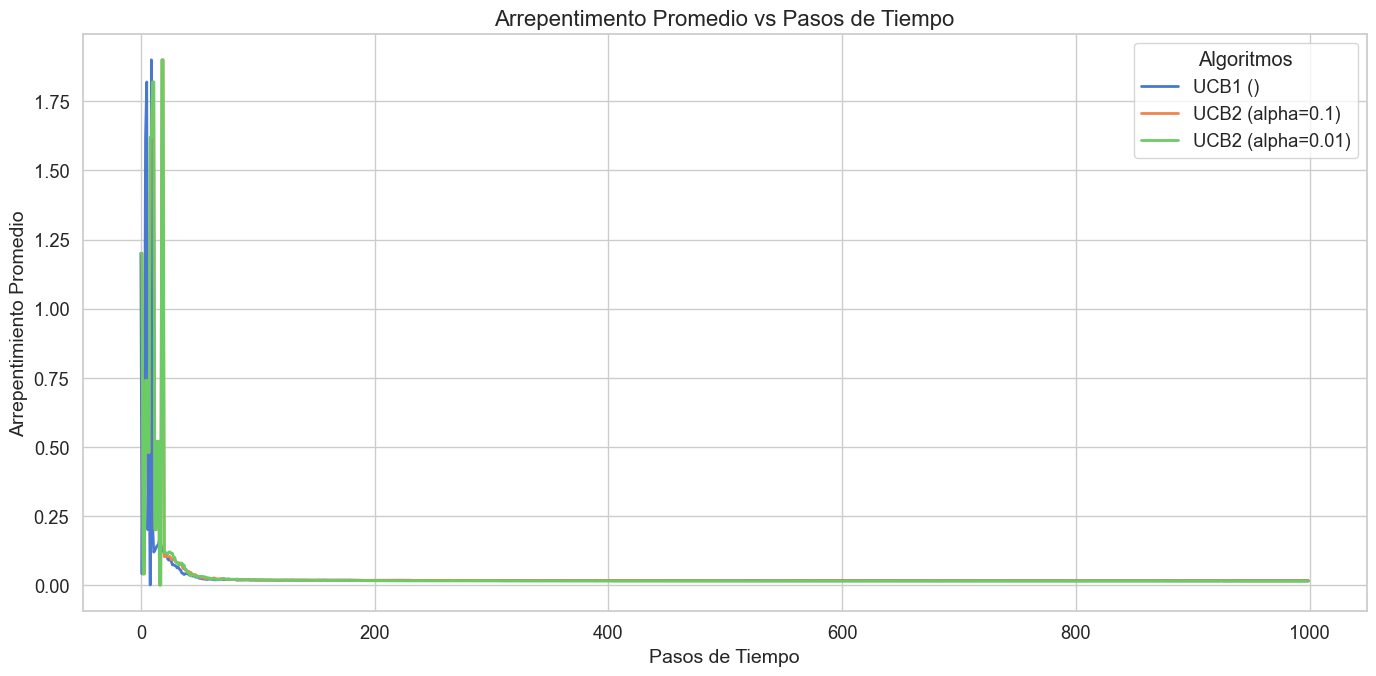

In [15]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Arrepentimiento promedio:**
   - La línea **azul (UCB1)** muestra algo de exploración al inicio, sobre todo al llevar a cabo uso de cada brazo en una pasada inicial. Tras ello, se ve como decrece el regret a los pocos pasos tras seleccionar el brazo óptimo.
   - La línea **naranja (UCB2; alpha = 0.1)** lleva a cabo algo más de exploración que lo mostrado por la línea azul, y de igual forma, tras unos pocos pasos el regret decrece de forma significativa al alcanzar el brazo óptimo.
   - La línea **verde (UCB2; alpha = 0.01)** por último, lleva a cabo más exploración que los otros 2 casos, debido al bajo valor de alpha establecido. Pese a ello, tras unos pocos pasos alcanza el brazo óptimo de igual forma que UCB1 y UCB2 con alpha=0.1, de tal forma que el valor obtenido de regret es considerablemente bajo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado en el estudio de los algoritmos UCB1 y UCB2, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
Los algoritmos **UCB1** y **UCB2** balancean entre exploración y explotación:
- **UCB1**: Seleccionará el brazo con mayor valor UCB, siendo este la suma entre la recompensa esperada y el resultado de u(a), obtenido mediante la fórmula $\sqrt{\frac{2 \ln t}{N_t(a)}}$
- **UCB2 (alpha=0.1)**: Al igual, que UCB1, para seleccionar el brazo a emplear, realiza la suma entre el valor esperado de cada brazo con u(a), en esta ocasión siendo dicho valor calculado mediante $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Al establecer un valor de alpha 0.1, el valor de tau crece algo lento, permitiendo cierta exploración.
- **UCB2 (alpha=0.01)**: Se emplea igual la fórmula $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$ para el cálculo de u(a). En esta ocasión, como el valor de alpha es menor (0.01), el denominador de u(a) crece de forma más lenta que antes, permitiendo que dicho carácter exploratorio sea mayor en esta ocasión.


Los gráficos confirman este comportamiento:
- **azul (UCB1)** realiza una rápida exploración al inicio, y tarda poco en alcanzar el brazo óptimo, pasando en una primera instancia por cada uno de los brazos. Se observa sin embargo, que suele ofrecer un resultado ligeramente inferior a UCB2 ya que selecciona en menor cantidad de ocasiones el brazo óptimo.
- **naranja (UCB2; alpha=0.1)** al poseer un valor alpha ciertamente grande se aprecia como la exploración que realiza es similar a la de UCB1, vemos sin embargo que el desempeño de este algoritmo con este valor mejora de forma ligera los resultados obtenidos por UCB1 seleccionando una mayor cantidad de veces el brazo óptimo.
- **verde (UCB2; alpha=0.01)** muestra una mayor exploración al tener un valor alpha pequeño, además se observa en los resultados obtenidos superan por norma a los que se obtienen mediante UCB1.

#### **2. Convergencia de los algoritmos**
La convergencia de los algoritmos UCB1 y UCB2 con alpha=0.1 es ligeramente superior a la de UCB2 con alpha=0.01:
- Por el funcionamiento de UCB, siempre se realizará una pasada por cada uno de los brazos en una ronda inicial.
- Dicha pasada permite observar las recompensas de cada brazo, por lo que pese a que UCB2 con alpha 0.01 explore más, los otros algoritmos pueden alcanzar el brazo óptimo de una forma rápida.
- Pese a la convergencia rápida de UCB1, se aprecia que selecciona el brazo óptimo un número inferior de veces a lo que lo hace UCB2.


#### **3. Utilidad Graficos**

El gráfico de recompensa promedio nos permite analizar cómo los algoritmos mejoran en las recompensas obtenidas, ayudándonos a determinar si están identificando brazos con buenas recompensas o incluso el brazo óptimo. Evaluar el equilibrio entre exploración y explotación facilita la comprensión del comportamiento del algoritmo.

La gráfica de Selección del Brazo Óptimo refleja el proceso de exploración y explotación, permitiéndonos observar si los algoritmos identifican y priorizan el brazo óptimo, si continúan explorando otras opciones o si existe una falta de exploración que impida encontrar la mejor alternativa.

La gráfica de Estadísticas de Brazos proporciona información detallada sobre cada brazo, como su porcentaje de selecciones, la recompensa promedio obtenida, su identificación y si es el brazo óptimo. Esta información resulta útil para analizar la diferencia en recompensas entre los brazos, si el algoritmo está explotando el brazo óptimo o algún otro, así como el nivel de exploración y la distribución de selecciones.

Por último, la gráfica del Arrepentimiento Promedio nos muestra cómo varía este valor para cada algoritmo, lo que nos ayuda a interpretar sus decisiones en la selección de brazos, identificando si están eligiendo el brazo óptimo o si persisten en la explotación de otra opción.

Como valoración general, las gráficas que más información nos aportan son la de la recompensa promedio de cada algoritmo, así como la de selección del brazo óptimo. Y es que según el nivel de recompensas que se esté obteniendo, se puede intuir si el brazo óptimo está siendo seleccionado, o si por el contrario no ha sido alcanzado. Del mismo modo, al ser el arrepentimiento una gráfica que representa la diferencia entre la recompensa máxima y la obtenida en cada paso, observando los valores obtenidos en la gráfica de recompensa promedio también se puede intuir cómo será dicha gráfica de arrepentimiento.

#### **4. Aplicaciones y conclusiones**
- El algoritmo de UCB (Upper Confidence Bound) es útil en aquellos campos donde es algo crucial el balance entre exploración y explotación, ejemplos de esto podría ser optimización de publicidad en páginas web, ensayos clínicos, sistemas de recomendación en plataformas de streaming...

Para esta distribución binomial, al igual que ocurría con al distribución normal, los mejores resultados vemos que han sido los obtenidos con UCB2, siendo de ellos los mejores los de alpha=0.1 y posteriormente alpha=0.01. Quedando por último UCB1.

## Distribución Bernoulli

### Ejecución del experimento

Ahora continuamos con la distribución de Bernoulli

In [16]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.01)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBenoulli(p=0.37), ArmBenoulli(p=0.95), ArmBenoulli(p=0.6), ArmBenoulli(p=0.73), ArmBenoulli(p=0.16), ArmBenoulli(p=0.06), ArmBenoulli(p=0.87), ArmBenoulli(p=0.71), ArmBenoulli(p=0.97), ArmBenoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


### Visualización de los resultados

#### Evolución Recompensa Promedio

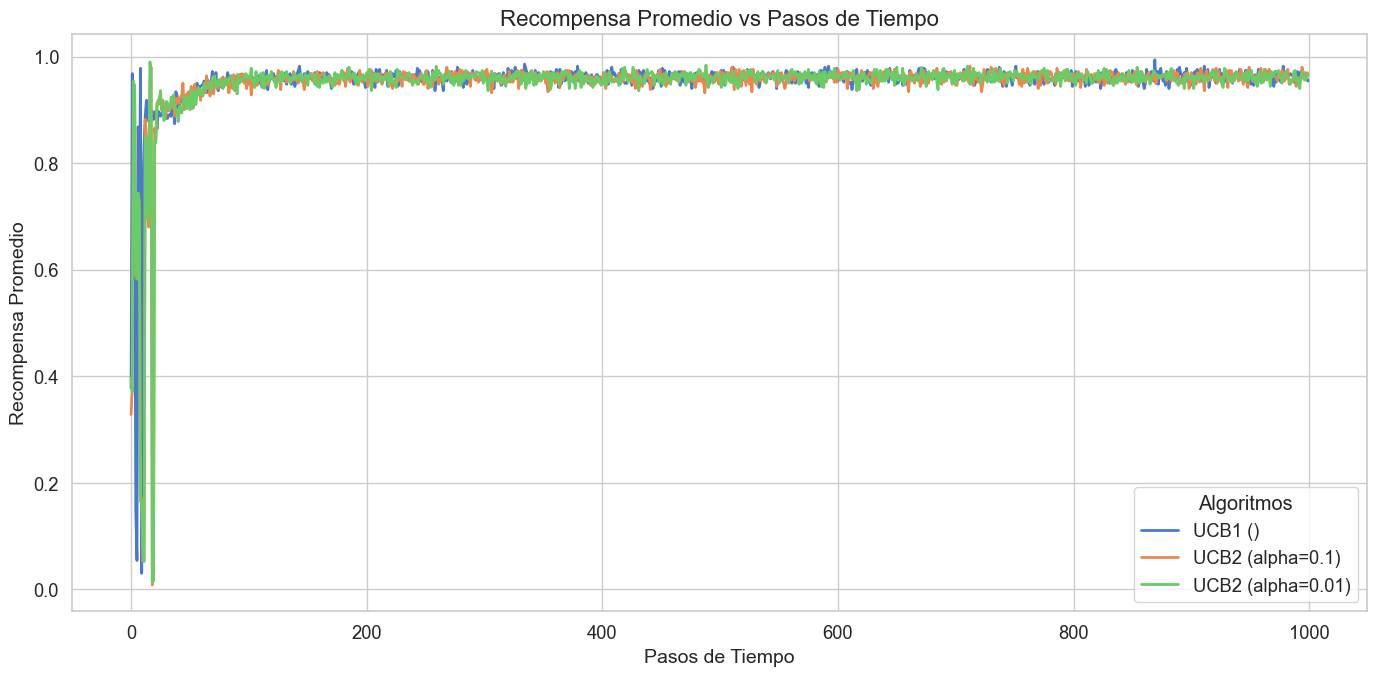

In [17]:
plot_average_rewards(steps, rewards, algorithms)

#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **UCB** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Crecimiento de la recompensa promedio:**
   - La línea **azul (UCB1)** siguiendo las tendencias anteriores, tras unos pocos pasos alcanza el brazo óptimo, donde comienza a explotar.
   - La línea **naranja (UCB2; alpha = 0.1)** de igual forma, comienza probando con todos los brazos y tras ello, en pocos pasos es capaz de alcanzar el brazo óptimo.
   - La línea **verde (UCB2; alpha = 0.01)** alcanza también el brazo óptimo en unos pocos pasos. A diferencia de lo que ocurría con otras distribuciones de probabilidad, en esta ocasión, los tres alcanzan el brazo óptimo prácticamente con el mismo número de pasos.


---

#### Evolución Selección Brazo Optimo


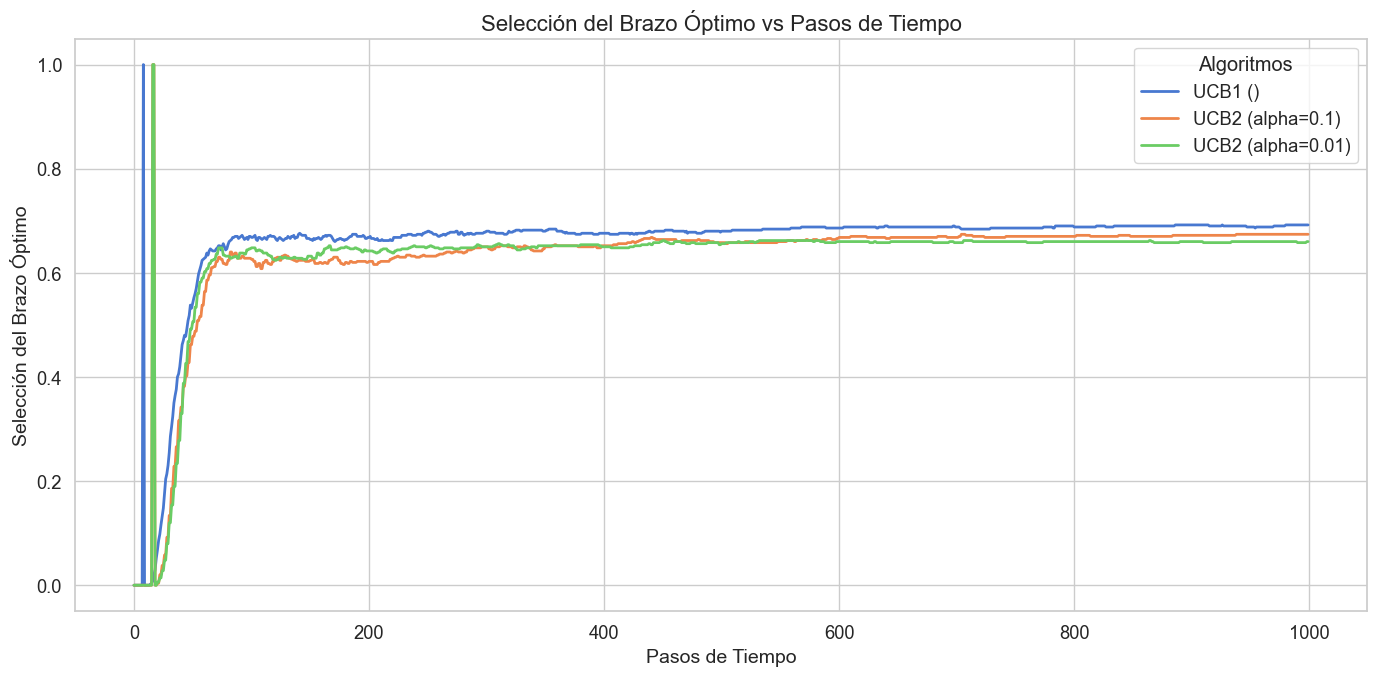

In [18]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Selección del brazo óptimo:**
   - La línea **azul (UCB1)** comienza con la exploración y alrededor de los 70 steps alcanza el brazo óptimo. En una primera instancia el brazo óptimo es seleccionado por realizar una primera pasada por cada uno de los brazos. Vemos aún así, que el porcentaje de selección del brazo óptimo es similar a lo que ocurría con la distribución de probabilidad binomial.
   - La línea **naranja (UCB2; alpha = 0.1)** explora por los brazos en una primera ronda, y tras ello, en pocos pasos, de igual forma que UCB1 alcanza el brazo óptimo, aunque se puede observar que lo selecciona un número de veces lígeramente inferior.
   - La línea **verde (UCB2; alpha = 0.01)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido cuál es el brazo óptimo y una vez conocido como sabe que es el que mejor recompensa promedio le puede dar, pues comienza a explotar esa opción. Aunque menos que en experimentos previos

---

#### Estadisticas de los brazos

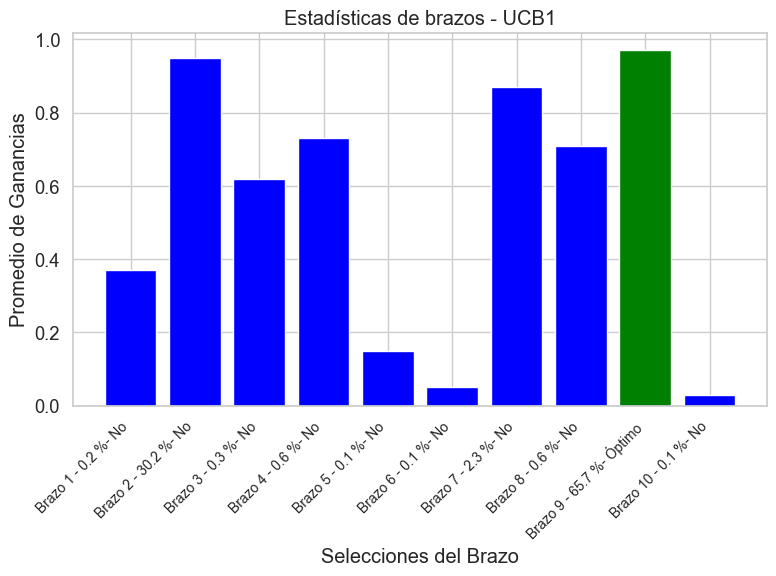

Recompensa Promedio del Brazo 1 : 0.37
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.62
Recompensa Promedio del Brazo 4 : 0.73
Recompensa Promedio del Brazo 5 : 0.15
Recompensa Promedio del Brazo 6 : 0.05
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.03


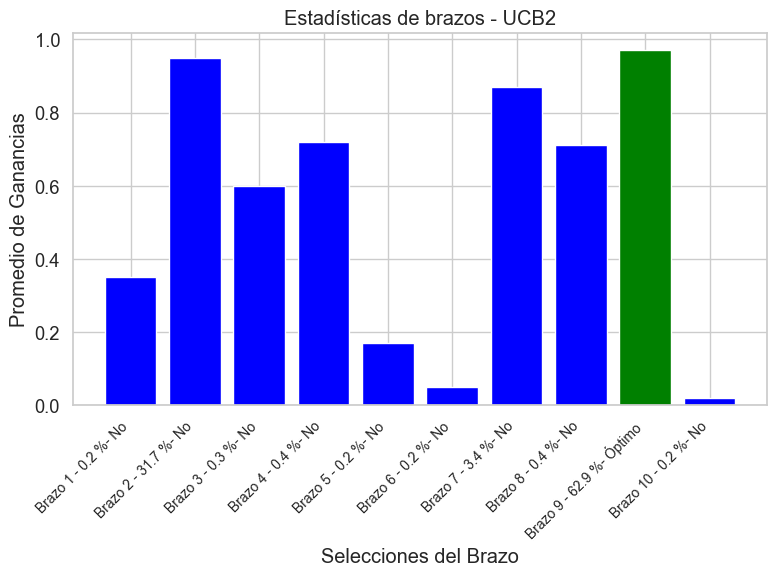

Recompensa Promedio del Brazo 1 : 0.35
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.6
Recompensa Promedio del Brazo 4 : 0.72
Recompensa Promedio del Brazo 5 : 0.17
Recompensa Promedio del Brazo 6 : 0.05
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


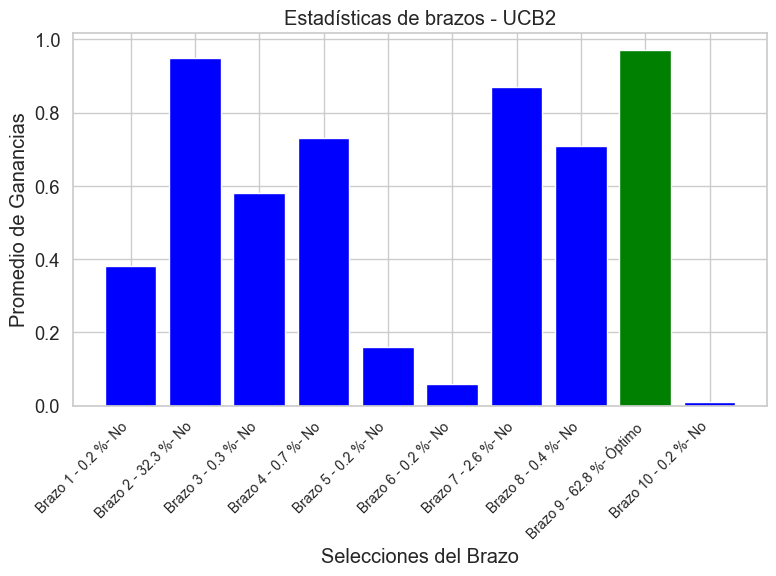

Recompensa Promedio del Brazo 1 : 0.38
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.58
Recompensa Promedio del Brazo 4 : 0.73
Recompensa Promedio del Brazo 5 : 0.16
Recompensa Promedio del Brazo 6 : 0.06
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.01


In [19]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **UCB** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de alpha en el algoritmo UCB:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo UCB1, con una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.1, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo UCB2 con alpha = 0.01, que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$, este alpha algo menor al anterior permite una mayor exploración.


2. **Estadísticas brazos**
   - En el primer histograma se observa un resultado similar a lo obtenido con la distribución binomial. Se alcanza el brazo óptimo, que además es el que se ha seleccionado de una forma mayoritaria, un 65.7% de las ocasiones, seguido del brazo 2, igual que ocurría anteriormente con un 30.2% debido a que ambas ofrecen una recompensa bastante similar.
   - En el segundo histograma, que refleja el uso de UCB2 con alpha=0.1 se aprecia de nuevo que se alcanza el brazo óptimo, siendo este seleccionado el 62.9% de las ocasiones, por lo que vemos que en este caso UCB1 proporciona un mejor comportamiento al elegir una mayor cantidad de veces el brazo óptimo.
   - Para el tercer histograma, el cual refleja el uso de UCB2 con alpha=0.01, se ve como también alcanza el brazo 9, que es el óptimo, sin embargo, también es notable, que es de los 3 el que menos veces selecciona dicho brazo, quedándose ligeramente por debajo de UCB2 con alpha=0.1, ya que el porcentaje de selección ahroa del brazo óptimo es de 62.8%. Al igual que ocurre en los otros 2 casos y con la distribución binomial, se da que el brazo 2 también es seleccionado gran parte de las veces (32.3%) ya que la recompensa que ofrece es ciertamente cercana a la ofrecida por el brazo óptimo.

---

#### Evolución del arrepentimiento promedio.

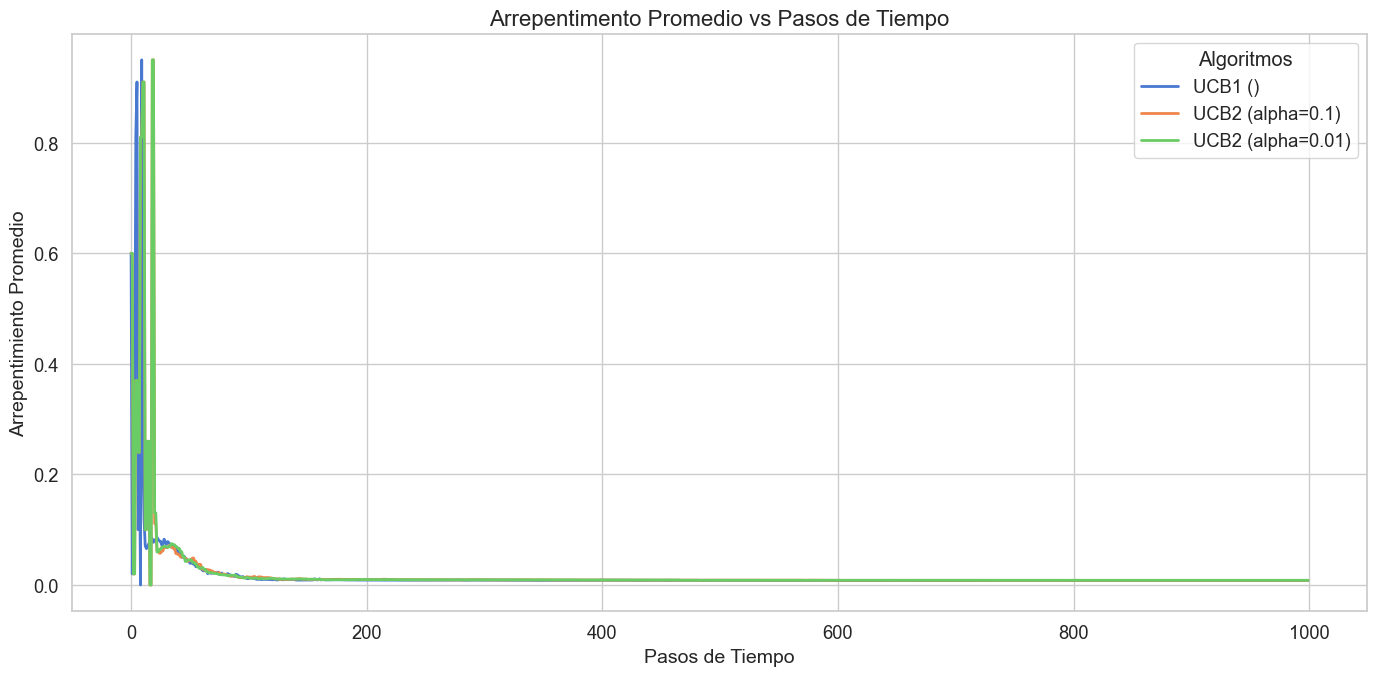

In [20]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **UCB** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de alpha en el algoritmo UCB:**
   - **Azul (UCB1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{2 \ln t}{N_t(a)}}$, siendo **t** el número total de veces que han seleccionado los brazos, y **N_t(a)** el número de veces que se ha seleccionado un brazo en concreto
   - **Naranja (UCB2; alpha = 0.1):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.1, permite que haya cierta exploración para encontrar el brazo óptimo.
   - **Verde (UCB2; alpha = 0.01):** Representa una estrategia que varía entre exploración y explotación según **Q(a) + u(a)**. Donde u(a) = $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Con alpha a 0.01, lo que aumenta aún más la exploración con objetivo de encontrar el brazo óptimo.

2. **Arrepentimiento promedio:**
   - La línea **azul (UCB1)** muestra una exploración inicial al probar cada brazo al menos una vez. Luego, el regret disminuye rápidamente a medida que identifica y selecciona el brazo óptimo.
   - La línea **naranja (UCB2; alpha = 0.1)** realiza una exploración ligeramente mayor que la azul, pero de manera similar, su regret se reduce significativamente tras unos pocos pasos al encontrar el brazo óptimo.
   - La línea **verde (UCB2; alpha = 0.01)** explora aún más debido al menor valor de alpha (0.01). Sin embargo, al igual que los otros dos casos, converge rápidamente al brazo óptimo, logrando un regret bajo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado en el estudio de los algoritmos UCB1 y UCB2, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
Los algoritmos **UCB1** y **UCB2** balancean entre exploración y explotación:
- **UCB1**: Seleccionará el brazo con mayor valor UCB, siendo este la suma entre la recompensa esperada y el resultado de u(a), obtenido mediante la fórmula $\sqrt{\frac{2 \ln t}{N_t(a)}}$
- **UCB2 (alpha=0.1)**: Al igual, que UCB1, para seleccionar el brazo a emplear, realiza la suma entre el valor esperado de cada brazo con u(a), en esta ocasión siendo dicho valor calculado mediante $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$. Al establecer un valor de alpha 0.1, el valor de tau crece algo lento, permitiendo cierta exploración.
- **UCB2 (alpha=0.01)**: Se emplea igual la fórmula $\sqrt{\frac{(1 + \alpha) \ln \left( \frac{t}{\tau(k_a)} \right)}{2 \tau(k_a)}}$ para el cálculo de u(a). En esta ocasión, como el valor de alpha es menor (0.01), el denominador de u(a) crece de forma más lenta que antes, permitiendo que dicho carácter exploratorio sea mayor en esta ocasión.


Los gráficos confirman este comportamiento:
- **azul (UCB1)** realiza una rápida exploración al inicio, y tarda poco en alcanzar el brazo óptimo, pasando en una primera instancia por cada uno de los brazos. Se observa sin embargo, que suele ofrecer un resultado ligeramente inferior a UCB2 ya que selecciona en menor cantidad de ocasiones el brazo óptimo.
- **naranja (UCB2; alpha=0.1)** al poseer un valor alpha ciertamente grande se aprecia como la exploración que realiza es similar a la de UCB1, vemos sin embargo que el desempeño de este algoritmo con este valor mejora de forma ligera los resultados obtenidos por UCB1 seleccionando una mayor cantidad de veces el brazo óptimo.
- **verde (UCB2; alpha=0.01)** muestra una mayor exploración al tener un valor alpha pequeño, además se observa en los resultados obtenidos superan por norma a los que se obtienen mediante UCB1.

#### **2. Convergencia de los algoritmos**
La convergencia de los algoritmos UCB1 y UCB2 con alpha=0.1 es ligeramente superior a la de UCB2 con alpha=0.01:
- Por el funcionamiento de UCB, siempre se realizará una pasada por cada uno de los brazos en una ronda inicial.
- Dicha pasada permite observar las recompensas de cada brazo, por lo que pese a que UCB2 con alpha 0.01 explore más, los otros algoritmos pueden alcanzar el brazo óptimo de una forma rápida.
- Pese a la convergencia rápida de UCB1, se aprecia que selecciona el brazo óptimo un número inferior de veces a lo que lo hace UCB2.


#### **3. Utilidad Graficos**

El gráfico de recompensa promedio nos permite analizar cómo los algoritmos mejoran en las recompensas obtenidas, ayudándonos a determinar si están identificando brazos con buenas recompensas o incluso el brazo óptimo. Evaluar el equilibrio entre exploración y explotación facilita la comprensión del comportamiento del algoritmo.

La gráfica de Selección del Brazo Óptimo refleja el proceso de exploración y explotación, permitiéndonos observar si los algoritmos identifican y priorizan el brazo óptimo, si continúan explorando otras opciones o si existe una falta de exploración que impida encontrar la mejor alternativa.

La gráfica de Estadísticas de Brazos proporciona información detallada sobre cada brazo, como su porcentaje de selecciones, la recompensa promedio obtenida, su identificación y si es el brazo óptimo. Esta información resulta útil para analizar la diferencia en recompensas entre los brazos, si el algoritmo está explotando el brazo óptimo o algún otro, así como el nivel de exploración y la distribución de selecciones.

Por último, la gráfica del Arrepentimiento Promedio nos muestra cómo varía este valor para cada algoritmo, lo que nos ayuda a interpretar sus decisiones en la selección de brazos, identificando si están eligiendo el brazo óptimo o si persisten en la explotación de otra opción.

Como valoración general, las gráficas que más información nos aportan son la de la recompensa promedio de cada algoritmo, así como la de selección del brazo óptimo. Y es que según el nivel de recompensas que se esté obteniendo, se puede intuir si el brazo óptimo está siendo seleccionado, o si por el contrario no ha sido alcanzado. Del mismo modo, al ser el arrepentimiento una gráfica que representa la diferencia entre la recompensa máxima y la obtenida en cada paso, observando los valores obtenidos en la gráfica de recompensa promedio también se puede intuir cómo será dicha gráfica de arrepentimiento.

#### **4. Aplicaciones y conclusiones**
- El algoritmo de UCB (Upper Confidence Bound) es útil en aquellos campos donde es algo crucial el balance entre exploración y explotación, ejemplos de esto podría ser optimización de publicidad en páginas web, ensayos clínicos, sistemas de recomendación en plataformas de streaming...

En esta ocasión, se puede apreciar como para una distribución de valores de bernoulli el algoritmo que mejores resultados ha presentado ha sido UCB1, aunque de una forma ligera, mientras que para UCB2 ambos valores de alpha (0.1 y 0.01) han obtenido prácticamente los mismo resultados seleccionando casi en la misma cantidad de ocasiones el brazo óptimo.

## Conclusiones de la prueba

Como conclusiones podemos apreciar, que pese a cambios ligeros, los resultados que se obtienen de emplear UCB1 y UCB2 en esta ocasión son bastante similares, y es que ambos algoritmos tienen un componente de exploración que se realiza de forma dinámica dependiendo del cálculo del valor de u(a). La mayor diferencia se observa cuando los valores de alpha son pequeños, como en el caso de 0.01, donde la exploración que se realiza en un inicio es mayor a la que emplea UCB1.
Se destaca también, que para ambos algoritmos, en todos los casos se puede alcanzar el brazo óptimo sin problema, obteniendo buenos resultados.

En cuanto a las distintas distribuciones de probabilidad, se aprecia que los mejores resultados se obtienen cuando se emplea una distribución normal. Esto se debe a que en el caso de la distribución binomial y de bernoulli existía un segundo brazo que ofrecía una recompensa muy parecida a la del brazo óptimo, lo que provocaba que debido a la fórmula del cálculo de ucb, en ocasiones se optase por seleccionar dicho brazo en lugar del óptimo, al realizar algo más de exploración. Cosa que no ocurre en la distribución normal, ya que la diferencia entre la recompensa ofrecida por el brazo óptimo en comparación con el segundo brazo que más recompensa ofrece es algo más notoria.